In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/multilabel-video-game-dataset-v2/y_test.csv
/kaggle/input/multilabel-video-game-dataset-v2/X_test.csv
/kaggle/input/multilabel-video-game-dataset-v2/y_val.csv
/kaggle/input/multilabel-video-game-dataset-v2/y_train.csv
/kaggle/input/multilabel-video-game-dataset-v2/X_train.csv
/kaggle/input/multilabel-video-game-dataset-v2/X_val.csv
/kaggle/input/multilabel-video-game-dataset-v2/vgame_fulldata.csv


In [2]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import string
from wordcloud import STOPWORDS
import gc
import re
import operator
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

# 📌 Data Import and Validation
---

### 📝 Import Data and Check Data Distribution

In [3]:
# train df
X_train = pd.read_csv('/kaggle/input/multilabel-video-game-dataset-v2/X_train.csv')
y_train = pd.read_csv('/kaggle/input/multilabel-video-game-dataset-v2/y_train.csv')

# test df
X_test = pd.read_csv('/kaggle/input/multilabel-video-game-dataset-v2/X_test.csv')
y_test = pd.read_csv('/kaggle/input/multilabel-video-game-dataset-v2/y_test.csv')

# val df
X_val = pd.read_csv('/kaggle/input/multilabel-video-game-dataset-v2/X_val.csv')
y_val = pd.read_csv('/kaggle/input/multilabel-video-game-dataset-v2/y_val.csv')

In [4]:
print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}\n')

print(f'X_val shape: {X_val.shape}')
print(f'y_val shape: {y_val.shape}\n')

print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}\n')

X_train shape: (117197, 2)
y_train shape: (117197, 12)

X_val shape: (14650, 2)
y_val shape: (14650, 12)

X_test shape: (14650, 2)
y_test shape: (14650, 12)



### 📝 Tiny EDA for Train, Test, and Validation Set

In [5]:
from ast import literal_eval

y_train['new_genrelist'] = y_train['new_genrelist'].apply(literal_eval)
y_test['new_genrelist'] = y_test['new_genrelist'].apply(literal_eval)
y_val['new_genrelist'] = y_val['new_genrelist'].apply(literal_eval)

In [6]:
genre_cols = ['action','adventure','arcade','cardboard','indie','puzzle','quiz','rpg','simulation','strategy']

,action,adventure,arcade,cardboard,indie,puzzle,quiz,rpg,simulation,strategy
0,0.798954,0.633864,0.916517,0.985588,0.566269,0.884792,0.992491,0.862104,0.737425,0.813818
1,0.201046,0.366136,0.083483,0.014412,0.433731,0.115208,0.007509,0.137896,0.262575,0.186182


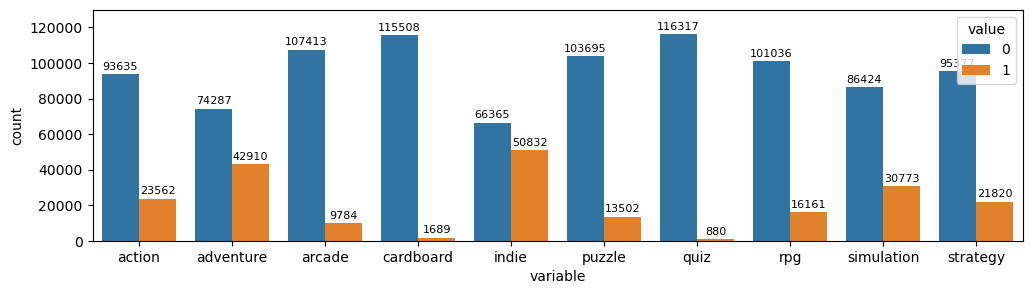

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

display(y_train[genre_cols].apply(lambda x: x.value_counts(normalize=True)))

plt.figure(figsize=(12,3))
ax = sns.countplot(x="variable", hue="value", data=pd.melt(y_train[genre_cols]))
ax.set_ylim(0,130000)

for container in ax.containers:
    ax.bar_label(container, label_type='edge', padding=2, fontsize=8)

plt.show()

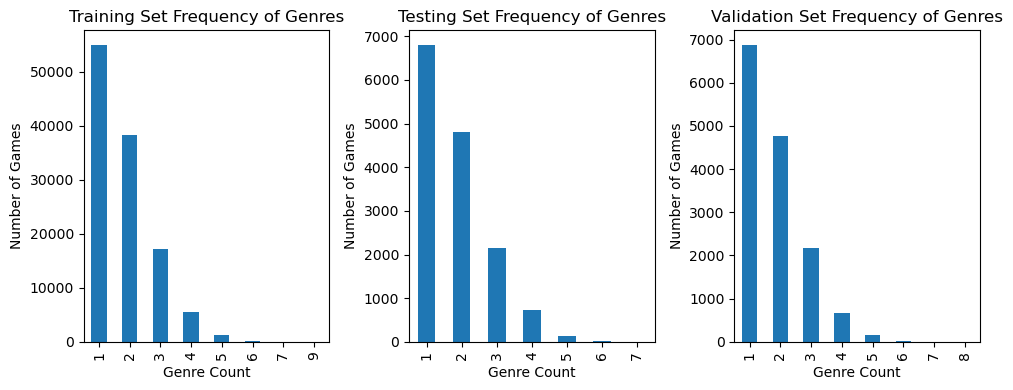

In [8]:
def freq_counter(df):
    freq_count = df['new_genrelist'].apply(len)
    return freq_count.value_counts()

training_freqcount = freq_counter(y_train)
testing_freqcount = freq_counter(y_test)
validation_freqcount = freq_counter(y_val)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 4))
training_freqcount.plot(kind='bar', title='Training Set Frequency of Genres', xlabel='Genre Count', ylabel='Number of Games', ax=ax1)
testing_freqcount.plot(kind='bar', title='Testing Set Frequency of Genres', xlabel='Genre Count', ylabel='Number of Games', ax=ax2)
validation_freqcount.plot(kind='bar', title='Validation Set Frequency of Genres', xlabel='Genre Count', ylabel='Number of Games', ax=ax3)
plt.tight_layout()

### 📝 Compile genre tags binary results to list then merge

In [9]:
y_train['compiled_genrelist'] = y_train[genre_cols].values.tolist()
y_val['compiled_genrelist'] = y_val[genre_cols].values.tolist()

merged_trainset = pd.merge(X_train, y_train, on='id')[['clean_summary', 'compiled_genrelist']]
merged_valset = pd.merge(X_val, y_val, on='id')[['clean_summary', 'compiled_genrelist']]

In [10]:
display(merged_trainset)
display(merged_valset)

,clean_summary,compiled_genrelist
0,a grid based single local multiplayer strategy...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1]"
1,top view racing game for wiiware by the makers...,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0]"
2,the idolmaster dearly stars is a japanese life...,"[0, 0, 0, 0, 0, 1, 0, 0, 1, 0]"
3,my daughter who was supposed to be dead is rig...,"[0, 0, 0, 0, 1, 0, 0, 0, 1, 0]"
4,espn baseball tonight is a baseball game with ...,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0]"
...,...,...
117192,kero kero king is the predecessor to ribbit ki...,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0]"
117193,mighty chameleon brothers will remind you of o...,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0]"
117194,take control of one of the iconic british loco...,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0]"
117195,alchemist of war is a casual card game with cr...,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0]"


,clean_summary,compiled_genrelist
0,a new legend begins here build and manage a to...,"[0, 1, 0, 0, 0, 0, 0, 1, 1, 1]"
1,meet barnsley a lazy good for nothing badger w...,"[1, 1, 0, 0, 0, 0, 0, 0, 0, 0]"
2,fire up a wild ride across the cosmos with a f...,"[1, 1, 0, 0, 0, 0, 0, 1, 0, 0]"
3,a special bonus disc that contained the both t...,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]"
4,kings cross a unique mix of strategy rpg and t...,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 1]"
...,...,...
14645,own the child of light ultimate edition with t...,"[1, 1, 0, 0, 0, 0, 0, 1, 0, 1]"
14646,a side scroller adventure game with a slight t...,"[1, 1, 0, 0, 1, 1, 0, 0, 0, 0]"
14647,welcome to the chess game of tomorrow yesterye...,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 1]"
14648,a capcom developed adventure game released exc...,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]"


# 📌 Handling Dataset Imbalance
---

# 📌 Preparation for Modelling
---

### 📝 Defining the Dataset Class

In [11]:
from torch.utils.data import Dataset, DataLoader

class MultiLabelDataset(Dataset):
    
    def __init__(self, df, tokenizer, max_len, new_data=False):
        self.tokenizer = tokenizer
        self.data = df
        self.text = df.clean_summary
        self.new_data = new_data
        self.max_len = max_len
        
        if not new_data:
            self.targets = self.data.compiled_genrelist
            
    def __len__(self):
        return len(self.text)
    
    def __getitem__(self, index):
        text = str(self.text[index])
        
        inputs = self.tokenizer.encode_plus(text,None,
                                           add_special_tokens=True,
                                           max_length=self.max_len,
                                           pad_to_max_length=True,
                                           return_token_type_ids=True)
        out = {
            "input_ids": torch.tensor(inputs['input_ids'], dtype=torch.long),
            "attention_mask": torch.tensor(inputs['attention_mask'], dtype=torch.long),
            "token_type_ids": torch.tensor(inputs['token_type_ids'], dtype=torch.long)
        }
        if not self.new_data:
            out["targets"] = torch.tensor(self.targets[index], dtype=torch.float)
            
        return out

### 📝 Defining the Configuration

In [12]:
MAX_LEN = 320
EPOCHS = 5
LEARNING_RATE = 1e-05
DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'
DEVICE

'cuda:0'

### 📝 Setting the Seeds

In [13]:
import os
import random
import torch

def seed_everything(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(42)

### 📝 Tokenizing and Creating Dataset then Loading it to the DataLoader

In [14]:
from transformers import DistilBertTokenizer

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased', truncation=True, do_lower_case=True)
train_set = MultiLabelDataset(merged_trainset, tokenizer, MAX_LEN)
val_set = MultiLabelDataset(merged_valset, tokenizer, MAX_LEN)

train_loader = DataLoader(train_set, batch_size=32, shuffle=True, num_workers=8)
val_loader = DataLoader(val_set, batch_size=32, shuffle=False, num_workers=8)

# 📌 Model Development
---

### 📝 Defining DistilBERT Class Model

In [15]:
from transformers import DistilBertModel

class DistilBertClass(torch.nn.Module):
    def __init__(self):
        super(DistilBertClass, self).__init__()
        
        self.bert = DistilBertModel.from_pretrained("distilbert-base-uncased")
        self.classifier = torch.nn.Sequential(torch.nn.Linear(768, 768),
                                             torch.nn.ReLU(),
                                             torch.nn.Dropout(0.1),
                                             torch.nn.Linear(768, 10))
        
    def forward(self, input_ids, attention_mask, token_type_ids):
        output_1 = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = output_1[0]
        out = hidden_state[:,0]
        out = self.classifier(out)
        return out

### 📝 Initializing the Model and Moving it to GPU

In [16]:
model = DistilBertClass()
model.to(DEVICE)
print(f"Model on {DEVICE}")

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Model on cuda:0


### 📝 Defining Optimizer and Loss Function

In [17]:
optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)

def loss_fn(outputs, targets):
    return torch.nn.functional.binary_cross_entropy_with_logits(outputs,targets)

### 📝 Defining Training Loop

In [18]:
from tqdm.auto import tqdm

loss_values = [[] for i in range(EPOCHS)]

def train(epoch):
    model.train()
    
    for _, data in tqdm(enumerate(train_loader)):
        input_ids = data['input_ids'].to(DEVICE, dtype=torch.long)
        attention_mask = data['attention_mask'].to(DEVICE, dtype=torch.long)
        token_type_ids = data['token_type_ids'].to(DEVICE, dtype=torch.long)
        targets = data['targets'].to(DEVICE, dtype=torch.float)
        
        outputs = model(input_ids, attention_mask, token_type_ids)
        
        loss = loss_fn(outputs, targets)
        
        if _ % 500 == 0:
            print(f"Epoch: {epoch}, Loss: {loss.item()}")
            loss_values[epoch].append(loss.item())
            
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

### 📝 Defining Validation Loop

In [19]:
from sklearn import metrics

def validate():
  model.eval()

  fin_targets = []
  fin_outputs = []

  with torch.inference_mode():
    for _, data in tqdm(enumerate(val_loader, 0)):
      ids = data['input_ids'].to(DEVICE, dtype=torch.long)
      mask = data['attention_mask'].to(DEVICE, dtype=torch.long)
      token_type_ids = data['token_type_ids'].to(DEVICE, dtype=torch.long)
      targets = data['targets'].to(DEVICE, dtype=torch.float)

      outputs = model(ids, mask, token_type_ids)
      fin_targets.extend(targets.cpu().detach().numpy().tolist())
      fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
      
  fin_outputs = np.array(fin_outputs) >= 0.5
  accuracy = metrics.accuracy_score(fin_targets, fin_outputs)
  f1_score_micro = metrics.f1_score(fin_targets, fin_outputs, average='micro')
  f1_score_macro = metrics.f1_score(fin_targets, fin_outputs, average='macro') 

  return {
      "Accuracy Score": accuracy,
      "F1 score(micro)": f1_score_micro,
      "F1 score(macro)": f1_score_macro
  }

# 📌 Model Training/Finetuning
---

### 📝 Execute Training and Validation Process

In [20]:
for epoch in range(EPOCHS):
  train(epoch)
  print(validate())
  print('#' * 30)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

0it [00:00, ?it/s]

Epoch: 0, Loss: 0.6955325603485107
Epoch: 0, Loss: 0.29036155343055725
Epoch: 0, Loss: 0.322954922914505
Epoch: 0, Loss: 0.3423134684562683
Epoch: 0, Loss: 0.35585877299308777
Epoch: 0, Loss: 0.24708619713783264
Epoch: 0, Loss: 0.23223161697387695
Epoch: 0, Loss: 0.25482290983200073


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

0it [00:00, ?it/s]

{'Accuracy Score': 0.3453924914675768, 'F1 score(micro)': 0.6579918594596875, 'F1 score(macro)': 0.5168835646081105}
##############################


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

0it [00:00, ?it/s]

Epoch: 1, Loss: 0.21788838505744934
Epoch: 1, Loss: 0.2817133069038391
Epoch: 1, Loss: 0.27860692143440247
Epoch: 1, Loss: 0.2976709306240082
Epoch: 1, Loss: 0.2458696812391281
Epoch: 1, Loss: 0.24252663552761078
Epoch: 1, Loss: 0.2522122859954834
Epoch: 1, Loss: 0.28046199679374695


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

0it [00:00, ?it/s]

{'Accuracy Score': 0.3610238907849829, 'F1 score(micro)': 0.6769820339541782, 'F1 score(macro)': 0.5715151872698033}
##############################


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

0it [00:00, ?it/s]

Epoch: 2, Loss: 0.21914136409759521
Epoch: 2, Loss: 0.20568056404590607
Epoch: 2, Loss: 0.2630515396595001
Epoch: 2, Loss: 0.33156928420066833
Epoch: 2, Loss: 0.2746712863445282
Epoch: 2, Loss: 0.20442934334278107
Epoch: 2, Loss: 0.24698007106781006
Epoch: 2, Loss: 0.18965719640254974


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

0it [00:00, ?it/s]

{'Accuracy Score': 0.375221843003413, 'F1 score(micro)': 0.6821145301274864, 'F1 score(macro)': 0.5653215526188367}
##############################


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

0it [00:00, ?it/s]

Epoch: 3, Loss: 0.23567461967468262
Epoch: 3, Loss: 0.19972382485866547
Epoch: 3, Loss: 0.1569318026304245
Epoch: 3, Loss: 0.21902723610401154
Epoch: 3, Loss: 0.25932660698890686
Epoch: 3, Loss: 0.21567773818969727
Epoch: 3, Loss: 0.2690725028514862
Epoch: 3, Loss: 0.2616322636604309


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

0it [00:00, ?it/s]

{'Accuracy Score': 0.37897610921501707, 'F1 score(micro)': 0.69679091090293, 'F1 score(macro)': 0.592387148640088}
##############################


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

0it [00:00, ?it/s]

Epoch: 4, Loss: 0.22786493599414825
Epoch: 4, Loss: 0.1811387538909912
Epoch: 4, Loss: 0.2034001350402832
Epoch: 4, Loss: 0.2110411375761032
Epoch: 4, Loss: 0.21533799171447754
Epoch: 4, Loss: 0.1733141988515854
Epoch: 4, Loss: 0.21738183498382568
Epoch: 4, Loss: 0.19006431102752686


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

0it [00:00, ?it/s]

{'Accuracy Score': 0.37597269624573376, 'F1 score(micro)': 0.6915738952064207, 'F1 score(macro)': 0.5882322959465079}
##############################


# 📌 Model Testing/Predictions
---

### 📝 Creating Test Dataset then Loading it to the DataLoader

In [21]:
X_test

,id,clean_summary
0,169256,visit a variety of water attractions with jasm...
1,33905,how to play a game that doesn want to be playe...
2,81241,these are the last days of the first planet ex...
3,6601,it time to get the party started right with so...
4,69434,is a non interactive short simple story follow...
...,...,...
14645,158107,disc golf valley is home to some of the most b...
14646,52238,sequel to the hit game happy wars a game that ...
14647,164170,driiift your way through tons of obstacles and...
14648,137139,select characters have been chosen to debut as...


In [22]:
test_set = MultiLabelDataset(X_test, tokenizer, MAX_LEN, new_data=True)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False, num_workers=8)

### 📝 Use Trained Model to Predict on Test Data

In [23]:
all_test_pred = []

def prediction():
  model.eval()

  with torch.inference_mode():
    for _, data in tqdm(enumerate(test_loader, 0)):
      ids = data['input_ids'].to(DEVICE, dtype=torch.long)
      mask = data['attention_mask'].to(DEVICE, dtype=torch.long)
      token_type_ids = data['token_type_ids'].to(DEVICE, dtype=torch.long)
      outputs = model(ids, mask, token_type_ids)
      probas = torch.sigmoid(outputs)

      all_test_pred.append(probas)
  return probas
probabilities = prediction()

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

0it [00:00, ?it/s]

In [24]:
all_test_pred = torch.cat(all_test_pred)

In [26]:
submit_df = X_test.copy()
submit_df.drop('clean_summary', inplace=True, axis=1)

In [27]:
for i,name in enumerate(genre_cols):

    submit_df[name] = all_test_pred[:, i].cpu()
    submit_df.head()

In [28]:
submit_df.to_csv('/kaggle/working/submission.csv', index=False)

In [29]:
submit_df

,id,action,adventure,arcade,cardboard,indie,puzzle,quiz,rpg,simulation,strategy
0,169256,0.000479,0.706762,0.000352,0.000102,0.738905,0.001617,0.000025,0.066912,0.434452,0.010809
1,33905,0.072547,0.313193,0.022499,0.005356,0.874638,0.161144,0.002319,0.088071,0.154959,0.265607
2,81241,0.163702,0.779423,0.008010,0.000241,0.815389,0.001117,0.000066,0.209691,0.028639,0.022843
3,6601,0.007965,0.017008,0.877716,0.038254,0.012781,0.028846,0.006922,0.009072,0.308571,0.018817
4,69434,0.003050,0.711799,0.000805,0.000070,0.874610,0.014106,0.000037,0.051748,0.097355,0.002803
...,...,...,...,...,...,...,...,...,...,...,...
14645,158107,0.001356,0.030677,0.057770,0.000405,0.198693,0.003224,0.000096,0.006394,0.996427,0.008825
14646,52238,0.136153,0.388141,0.023115,0.005448,0.341562,0.011423,0.002123,0.747149,0.037178,0.310648
14647,164170,0.399451,0.152926,0.437658,0.001114,0.258837,0.043208,0.001225,0.005305,0.242246,0.034709
14648,137139,0.004717,0.003869,0.041148,0.036536,0.010300,0.962461,0.011169,0.000988,0.006625,0.152740


# 📌 Model Evaluation
---

### 📝 Show Proababilities and Actual Values Dataframe

In [42]:
predictions_df = submit_df
predictions_df

,id,action,adventure,arcade,cardboard,indie,puzzle,quiz,rpg,simulation,strategy
0,169256,0.000479,0.706762,0.000352,0.000102,0.738905,0.001617,0.000025,0.066912,0.434452,0.010809
1,33905,0.072547,0.313193,0.022499,0.005356,0.874638,0.161144,0.002319,0.088071,0.154959,0.265607
2,81241,0.163702,0.779423,0.008010,0.000241,0.815389,0.001117,0.000066,0.209691,0.028639,0.022843
3,6601,0.007965,0.017008,0.877716,0.038254,0.012781,0.028846,0.006922,0.009072,0.308571,0.018817
4,69434,0.003050,0.711799,0.000805,0.000070,0.874610,0.014106,0.000037,0.051748,0.097355,0.002803
...,...,...,...,...,...,...,...,...,...,...,...
14645,158107,0.001356,0.030677,0.057770,0.000405,0.198693,0.003224,0.000096,0.006394,0.996427,0.008825
14646,52238,0.136153,0.388141,0.023115,0.005448,0.341562,0.011423,0.002123,0.747149,0.037178,0.310648
14647,164170,0.399451,0.152926,0.437658,0.001114,0.258837,0.043208,0.001225,0.005305,0.242246,0.034709
14648,137139,0.004717,0.003869,0.041148,0.036536,0.010300,0.962461,0.011169,0.000988,0.006625,0.152740


In [43]:
actual_df = y_test
actual_df

,id,new_genrelist,action,adventure,arcade,cardboard,indie,puzzle,quiz,rpg,simulation,strategy
0,169256,"[adventure, indie]",0,1,0,0,1,0,0,0,0,0
1,33905,"[indie, puzzle]",0,0,0,0,1,1,0,0,0,0
2,81241,[adventure],0,1,0,0,0,0,0,0,0,0
3,6601,"[arcade, simulation]",0,0,1,0,0,0,0,0,1,0
4,69434,"[adventure, indie]",0,1,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
14645,158107,[simulation],0,0,0,0,0,0,0,0,1,0
14646,52238,[rpg],0,0,0,0,0,0,0,1,0,0
14647,164170,"[indie, simulation]",0,0,0,0,1,0,0,0,1,0
14648,137139,"[puzzle, strategy]",0,0,0,0,0,1,0,0,0,1


### 📝 Calculate for AUC ROC Score

In [45]:
%pip install -q torchmetrics watermark

Note: you may need to restart the kernel to use updated packages.


In [46]:
%load_ext watermark

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark


In [47]:
%watermark --iversions

seaborn     : 0.12.2
numpy       : 1.21.6
re          : 2.2.1
torchmetrics: 0.11.4
matplotlib  : 3.5.3
pandas      : 1.3.5
sklearn     : 1.0.2
torch       : 1.13.0



In [170]:
# Score for each cat
import torchmetrics

for cat in genre_cols:
    
    print(f"Category: {cat}")
    print(f"Sklearn score: {metrics.roc_auc_score(actual_df[cat], predictions_df[cat])}")
#     print(f"Sklearn score: {metrics.roc_auc_score(actual_df[cat], predictions_df[cat], average='weighted')}")
    print(f"torchmetrics score: {torchmetrics.functional.classification.binary_auroc(torch.tensor(predictions_df[cat].values),torch.tensor(actual_df[cat].values), thresholds=None)}")
    print("#" * 30)
    print()

Category: action
Sklearn score: 0.901818525683683
torchmetrics score: 0.9018185138702393
##############################

Category: adventure
Sklearn score: 0.8736008162755147
torchmetrics score: 0.8736007809638977
##############################

Category: arcade
Sklearn score: 0.8469759138930442
torchmetrics score: 0.8469759225845337
##############################

Category: cardboard
Sklearn score: 0.9273213829949101
torchmetrics score: 0.9273214936256409
##############################

Category: indie
Sklearn score: 0.8768752722731937
torchmetrics score: 0.8768752813339233
##############################

Category: puzzle
Sklearn score: 0.8941645853991799
torchmetrics score: 0.8941646218299866
##############################

Category: quiz
Sklearn score: 0.9425251461307333
torchmetrics score: 0.9425250887870789
##############################

Category: rpg
Sklearn score: 0.89530976284585
torchmetrics score: 0.8953096866607666
##############################

Category: simulation
Sklear

In [171]:
# mean column-wise score on all categories
print(f"Sklearn score(micro): {metrics.roc_auc_score(actual_df[genre_cols].values, predictions_df[genre_cols].values,average='micro')}")
print(F"torchmetrics score(micro): {torchmetrics.functional.classification.multilabel_auroc(torch.tensor(predictions_df[genre_cols].values),torch.tensor(actual_df[genre_cols].values),num_labels=10,thresholds=None,average='micro')}")

print()
print(f"Sklearn score(macro): {metrics.roc_auc_score(actual_df[genre_cols].values, predictions_df[genre_cols].values,average='macro')}")
print(F"torchmetrics score(macro): {torchmetrics.functional.classification.multilabel_auroc(torch.tensor(predictions_df[genre_cols].values),torch.tensor(actual_df[genre_cols].values),num_labels=10,thresholds=None,average='macro')}")

print()
print(f"Sklearn score(weighted): {metrics.roc_auc_score(actual_df[genre_cols].values, predictions_df[genre_cols].values, average='weighted')}")
print(F"torchmetrics score(weighted): {torchmetrics.functional.classification.multilabel_auroc(torch.tensor(predictions_df[genre_cols].values),torch.tensor(actual_df[genre_cols].values),num_labels=10,thresholds=None,average='weighted' )}")

Sklearn score(micro): 0.9234749986969268
torchmetrics score(micro): 0.9234750270843506

Sklearn score(macro): 0.893446912004135
torchmetrics score(macro): 0.8934469223022461

Sklearn score(weighted): 0.8840487576231454
torchmetrics score(weighted): 0.8840487599372864


### 📝 Calculate for Average Precision Score

In [172]:
# score for each genre categories

for cat in genre_cols:
    
    print(f"Category: {cat}")
    print(f"Sklearn score: {metrics.average_precision_score(actual_df[cat], predictions_df[cat])}")
#     print(f"Sklearn score: {metrics.average_precision_score(actual_df[cat], predictions_df[cat], average='weighted')}")
    print(f"torchmetrics score: {torchmetrics.functional.classification.binary_average_precision(torch.tensor(predictions_df[cat].values),torch.tensor(actual_df[cat].values), thresholds=None)}")
    print("#" * 30)
    print()

Category: action
Sklearn score: 0.7534572689770852
torchmetrics score: 0.753457248210907
##############################

Category: adventure
Sklearn score: 0.8019487145754448
torchmetrics score: 0.8019487261772156
##############################

Category: arcade
Sklearn score: 0.4450146607890901
torchmetrics score: 0.4450146555900574
##############################

Category: cardboard
Sklearn score: 0.3549895346051935
torchmetrics score: 0.35498952865600586
##############################

Category: indie
Sklearn score: 0.8216724085288862
torchmetrics score: 0.8216724395751953
##############################

Category: puzzle
Sklearn score: 0.6303377895273289
torchmetrics score: 0.6303378343582153
##############################

Category: quiz
Sklearn score: 0.43989133829081095
torchmetrics score: 0.43989133834838867
##############################

Category: rpg
Sklearn score: 0.6879034998855161
torchmetrics score: 0.6879035830497742
##############################

Category: simulation
S

In [173]:
# mean column-wise score on all categories
print()
print(f"Sklearn score(micro): {metrics.average_precision_score(actual_df[genre_cols].values, predictions_df[genre_cols].values, average='micro')}")
print(F"torchmetrics score(micro): {torchmetrics.functional.classification.multilabel_average_precision(torch.tensor(predictions_df[genre_cols].values),torch.tensor(actual_df[genre_cols].values),num_labels=10,thresholds=None, average='micro')}")

print()
print(f"Sklearn score(macro): {metrics.average_precision_score(actual_df[genre_cols].values, predictions_df[genre_cols].values, average='macro')}")
print(F"torchmetrics score(macro): {torchmetrics.functional.classification.multilabel_average_precision(torch.tensor(predictions_df[genre_cols].values),torch.tensor(actual_df[genre_cols].values),num_labels=10,thresholds=None, average='macro')}")

print()
print(f"Sklearn score(weighted): {metrics.average_precision_score(actual_df[genre_cols].values, predictions_df[genre_cols].values, average='weighted')}")
print(F"torchmetrics score(weighted): {torchmetrics.functional.classification.multilabel_average_precision(torch.tensor(predictions_df[genre_cols].values),torch.tensor(actual_df[genre_cols].values),num_labels=10,thresholds=None,average='weighted' )}")


Sklearn score(micro): 0.76978717185742
torchmetrics score(micro): 0.7697872519493103

Sklearn score(macro): 0.6497780881911017
torchmetrics score(macro): 0.6497780680656433

Sklearn score(weighted): 0.7563744144874869
torchmetrics score(weighted): 0.7563744783401489


## ⚠ Beyond this point, I am thresholding the predictions to 0.5. Be warned.

In [174]:
thresholded_preds = predictions_df.copy()

for cat in genre_cols:
    thresholded_preds[cat] = (thresholded_preds[cat] >= 0.5).astype(int)

display(predictions_df)
display(thresholded_preds)

,id,action,adventure,arcade,cardboard,indie,puzzle,quiz,rpg,simulation,strategy
0,169256,0.000479,0.706762,0.000352,0.000102,0.738905,0.001617,0.000025,0.066912,0.434452,0.010809
1,33905,0.072547,0.313193,0.022499,0.005356,0.874638,0.161144,0.002319,0.088071,0.154959,0.265607
2,81241,0.163702,0.779423,0.008010,0.000241,0.815389,0.001117,0.000066,0.209691,0.028639,0.022843
3,6601,0.007965,0.017008,0.877716,0.038254,0.012781,0.028846,0.006922,0.009072,0.308571,0.018817
4,69434,0.003050,0.711799,0.000805,0.000070,0.874610,0.014106,0.000037,0.051748,0.097355,0.002803
...,...,...,...,...,...,...,...,...,...,...,...
14645,158107,0.001356,0.030677,0.057770,0.000405,0.198693,0.003224,0.000096,0.006394,0.996427,0.008825
14646,52238,0.136153,0.388141,0.023115,0.005448,0.341562,0.011423,0.002123,0.747149,0.037178,0.310648
14647,164170,0.399451,0.152926,0.437658,0.001114,0.258837,0.043208,0.001225,0.005305,0.242246,0.034709
14648,137139,0.004717,0.003869,0.041148,0.036536,0.010300,0.962461,0.011169,0.000988,0.006625,0.152740


,id,action,adventure,arcade,cardboard,indie,puzzle,quiz,rpg,simulation,strategy
0,169256,0,1,0,0,1,0,0,0,0,0
1,33905,0,0,0,0,1,0,0,0,0,0
2,81241,0,1,0,0,1,0,0,0,0,0
3,6601,0,0,1,0,0,0,0,0,0,0
4,69434,0,1,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
14645,158107,0,0,0,0,0,0,0,0,1,0
14646,52238,0,0,0,0,0,0,0,1,0,0
14647,164170,0,0,0,0,0,0,0,0,0,0
14648,137139,0,0,0,0,0,1,0,0,0,0


### 📝 Getting Confusion Matrix

In [175]:
mlb_cm = metrics.multilabel_confusion_matrix(y_true=actual_df[genre_cols].values, y_pred=thresholded_preds[genre_cols].values)

,action,adventure,arcade,cardboard,indie,puzzle,quiz,rpg,simulation,strategy
0,0.797133,0.629283,0.912628,0.984573,0.568396,0.886212,0.992014,0.863481,0.736655,0.812082
1,0.202867,0.370717,0.087372,0.015427,0.431604,0.113788,0.007986,0.136519,0.263345,0.187918


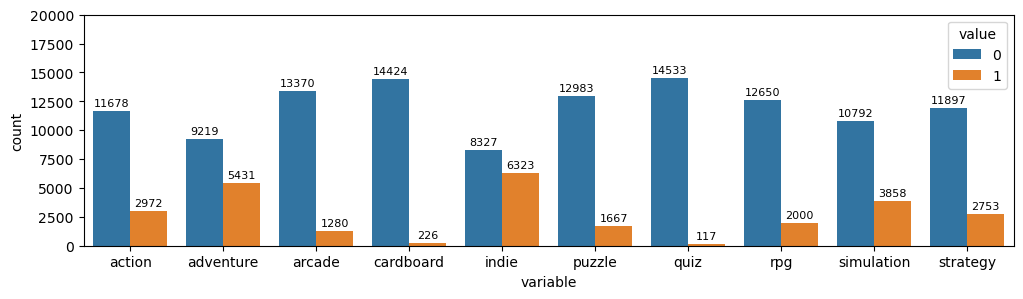

In [176]:
# displaying test set distribution as a proof of validation to our confusion matrices

display(y_test[genre_cols].apply(lambda x: x.value_counts(normalize=True)))

plt.figure(figsize=(12,3))
ax = sns.countplot(x="variable", hue="value", data=pd.melt(y_test[genre_cols]))
ax.set_ylim(0,20000)

for container in ax.containers:
    ax.bar_label(container, label_type='edge', padding=2, fontsize=8)

plt.show()

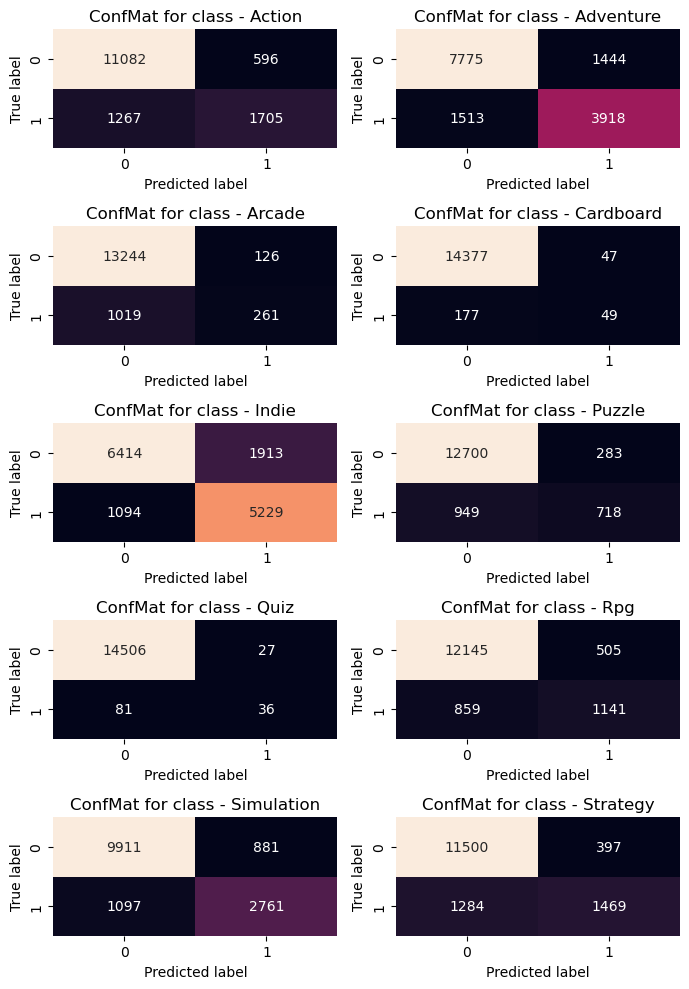

In [177]:
def print_confusion_matrix(confusion_matrix, axes, class_label, class_names):

    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,
    )

    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cbar=False, ax=axes)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
        
#     heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right')
#     heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right')
    axes.set_ylabel('True label')
    axes.set_xlabel('Predicted label')
    axes.set_title("ConfMat for class - " + class_label.capitalize())
    
fig, ax = plt.subplots(5, 2, figsize=(7, 10))
    
for axes, cfs_matrix, label in zip(ax.flatten(), mlb_cm, genre_cols):
    print_confusion_matrix(cfs_matrix, axes, label, ["0", "1"])

fig.tight_layout()
plt.show()

### 📝 Classification Report

In [186]:
print(metrics.classification_report(actual_df[genre_cols].values, thresholded_preds[genre_cols].values, target_names=genre_cols))

              precision    recall  f1-score   support

      action       0.74      0.57      0.65      2972
   adventure       0.73      0.72      0.73      5431
      arcade       0.67      0.20      0.31      1280
   cardboard       0.51      0.22      0.30       226
       indie       0.73      0.83      0.78      6323
      puzzle       0.72      0.43      0.54      1667
        quiz       0.57      0.31      0.40       117
         rpg       0.69      0.57      0.63      2000
  simulation       0.76      0.72      0.74      3858
    strategy       0.79      0.53      0.64      2753

   micro avg       0.74      0.65      0.69     26627
   macro avg       0.69      0.51      0.57     26627
weighted avg       0.73      0.65      0.68     26627
 samples avg       0.75      0.70      0.69     26627



### 📝 Getting F1 Score

In [187]:
for cat in genre_cols:
    
    print(f"Category: {cat}")
    print(f"Sklearn score: {metrics.f1_score(actual_df[cat], thresholded_preds[cat])}")
    print(f"torchmetrics score: {torchmetrics.functional.classification.binary_f1_score(torch.tensor(predictions_df[cat].values),torch.tensor(actual_df[cat].values))}")
#     print(f"torchmetrics score(orig): {torchmetrics.functional.classification.binary_f1_score(torch.tensor(thresholded_preds[cat].values),torch.tensor(actual_df[cat].values), threshold=0.5)}")
    print("#" * 30)
    print()

Category: action
Sklearn score: 0.6466906884126684
torchmetrics score: 0.6466906666755676
##############################

Category: adventure
Sklearn score: 0.7260261280459557
torchmetrics score: 0.7260261178016663
##############################

Category: arcade
Sklearn score: 0.3131373725254949
torchmetrics score: 0.31313738226890564
##############################

Category: cardboard
Sklearn score: 0.30434782608695654
torchmetrics score: 0.30434781312942505
##############################

Category: indie
Sklearn score: 0.7766802822131452
torchmetrics score: 0.7766802906990051
##############################

Category: puzzle
Sklearn score: 0.5382308845577212
torchmetrics score: 0.5382308959960938
##############################

Category: quiz
Sklearn score: 0.4
torchmetrics score: 0.4000000059604645
##############################

Category: rpg
Sklearn score: 0.6258913878222709
torchmetrics score: 0.625891387462616
##############################

Category: simulation
Sklearn score: 0

In [188]:
print(f"Sklearn score(micro): {metrics.f1_score(actual_df[genre_cols].values, thresholded_preds[genre_cols].values, average='micro')}")
print(f"torchmetrics score(micro): {torchmetrics.functional.classification.multilabel_f1_score(torch.tensor(thresholded_preds[genre_cols].values),torch.tensor(actual_df[genre_cols].values),num_labels=10,average='macro')}")

print()
print(f"Sklearn score(macro): {metrics.f1_score(actual_df[genre_cols].values, thresholded_preds[genre_cols].values, average='macro')}")
print(f"torchmetrics score(macro): {torchmetrics.functional.classification.multilabel_f1_score(torch.tensor(thresholded_preds[genre_cols].values),torch.tensor(actual_df[genre_cols].values),num_labels=10,average='macro')}")

print()
print(f"Sklearn score(weighted): {metrics.f1_score(actual_df[genre_cols].values, thresholded_preds[genre_cols].values, average='weighted')}")
print(f"torchmetrics score(weighted): {torchmetrics.functional.classification.multilabel_f1_score(torch.tensor(thresholded_preds[genre_cols].values),torch.tensor(actual_df[genre_cols].values),num_labels=10,average='weighted')}")

Sklearn score(micro): 0.689645542856003
torchmetrics score(micro): 0.5703339576721191

Sklearn score(macro): 0.5703339649407303
torchmetrics score(macro): 0.5703339576721191

Sklearn score(weighted): 0.6772444247847559
torchmetrics score(weighted): 0.6772444248199463
